In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
from IPython.display import Image
from sklearn.cluster import MeanShift

import matplotlib.pyplot as plt
import scipy.misc
import numpy as np
import tensorflow as tf
import cv2
import warnings
from distutils.version import LooseVersion
import glob

import os
from sklearn.model_selection import train_test_split

## Prepaire data

In [0]:
IMAGE_SIZE = (52, 52, 3)
RATE_DROP = 0.5

def prepaire_data(path):
  X_data = []
  y_data = []
  for file in os.listdir(path):
    path_img = os.path.join(path, file)
    img = cv2.imread(path_img)
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
    img = img/255.
    X_data.append(img)
    lb = np.int32(path_img[-5])
    y_data.append(lb)
  X_data = np.array(X_data)
  y_data = np.array(y_data)
  return X_data, y_data
    

In [0]:
!unzip ./drive/My\ Drive/Colab\ Notebooks/BTL/im_train_stage2.zip
!rm -r ./train_stage2/
!mkdir ./train_stage2
!mv ./*.png ./train_stage2

In [0]:
!unzip ./drive/My\ Drive/Colab\ Notebooks/BTL/test.zip
!rm -r ./test/
!mkdir ./test
!mv ./*.png ./test

In [0]:
path = './train_stage2'
X_data, y_data = prepaire_data(path)

In [0]:
X_data.shape

(1452, 52, 52, 3)

## Train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.15)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.35)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape

((802, 52, 52, 3), (218, 52, 52, 3), (802,), (218,), (432, 52, 52, 3), (432,))

In [0]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(cv2.cvtColor(np.uint8(X_train[121]*225), cv2.COLOR_RGB2BGR))

ax[0,1].imshow(cv2.cvtColor(np.uint8(X_train[11]*225), cv2.COLOR_RGB2BGR))

ax[1,0].imshow(cv2.cvtColor(np.uint8(X_train[1]*225), cv2.COLOR_RGB2BGR))

ax[1,1].imshow(cv2.cvtColor(np.uint8(X_train[3]*225), cv2.COLOR_RGB2BGR))


In [0]:
y_train[121], y_train[11], y_train[1], y_train[3]

(0, 3, 0, 3)

## Model

In [0]:
from keras.layers import Dense, Conv2D, Flatten, Reshape, Input, Activation, MaxPooling2D, BatchNormalization, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt

In [0]:
def build_model():
  model = Sequential()
  
  model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=1, padding='valid', input_shape=IMAGE_SIZE, use_bias=True, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
  model.add(BatchNormalization())
  
  model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='valid', use_bias=True, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
  model.add(BatchNormalization())
 
  model.add(Flatten(input_shape=IMAGE_SIZE))
  model.add(Dropout(rate=RATE_DROP))
  model.add(Dense(units=32, activation='relu', use_bias=True))
  model.add(Dense(units=4, activation='softmax'))
  
  return model
  

In [0]:
IMAGE_SIZE = (52, 52, 3)
RATE_DROP = 0.5
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 48, 48, 32)        2432      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 11, 11, 64)        256       
_________________________________________________________________
flatten_7 (Flatten)          (None, 7744)              0         
__________

In [0]:
filepath = 'model.h5'
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=3, mode='auto')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stoping = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
history = model.fit(X_train, y_train, epochs=20, batch_size=64,validation_data=(X_val, y_val),\
                          callbacks=[checkpoint, TensorBoard(log_dir='model'), reduce_lr], shuffle = True)

Train on 802 samples, validate on 432 samples
Epoch 1/20
802/802 [==============================] - 1s 869us/step - loss: 0.2330 - acc: 0.9190 - val_loss: 0.1255 - val_acc: 0.9838

Epoch 00001: val_acc improved from -inf to 0.98380, saving model to model.h5
Epoch 2/20
802/802 [==============================] - 0s 211us/step - loss: 0.0217 - acc: 0.9988 - val_loss: 0.1492 - val_acc: 0.9792

Epoch 00002: val_acc did not improve from 0.98380
Epoch 3/20
802/802 [==============================] - 0s 206us/step - loss: 0.0245 - acc: 0.9975 - val_loss: 0.1270 - val_acc: 0.9861

Epoch 00003: val_acc improved from 0.98380 to 0.98611, saving model to model.h5
Epoch 4/20
802/802 [==============================] - 0s 204us/step - loss: 0.0228 - acc: 0.9975 - val_loss: 0.1189 - val_acc: 0.9907

Epoch 00004: val_acc improved from 0.98611 to 0.99074, saving model to model.h5
Epoch 5/20
802/802 [==============================] - 0s 200us/step - loss: 0.0209 - acc: 0.9988 - val_loss: 0.1165 - val_acc: 

In [0]:
import numpy as np
y_pred = model.evaluate(X_test, y_test)
y_pred

218/218 [==============================] - 0s 159us/step


[2.0385333643656467e-05, 1.0]

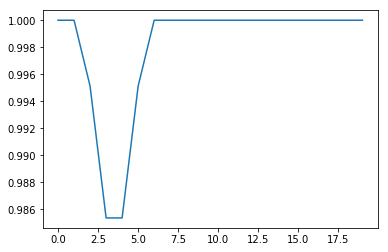

In [0]:
plt.plot(np.arange(0, len(history.history['val_acc'])),history.history['val_acc'])


### Save model

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
